In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/data
!unzip /content/drive/MyDrive/data/handwrittings_dataset.zip -d /content/data

Archive:  /content/drive/MyDrive/data/handwrittings_dataset.zip
   creating: /content/data/test/
  inflating: /content/data/test/h1000.png  
  inflating: /content/data/test/h1001.png  
  inflating: /content/data/test/h1002.png  
  inflating: /content/data/test/h1003.png  
  inflating: /content/data/test/h1004.png  
  inflating: /content/data/test/h1005.png  
  inflating: /content/data/test/h1006.png  
  inflating: /content/data/test/h1007.png  
  inflating: /content/data/test/h1008.png  
  inflating: /content/data/test/h1009.png  
  inflating: /content/data/test/h1010.png  
  inflating: /content/data/test/h1011.png  
  inflating: /content/data/test/h1012.png  
  inflating: /content/data/test/h1013.png  
  inflating: /content/data/test/h1014.png  
  inflating: /content/data/test/h1015.png  
  inflating: /content/data/test/h1016.png  
  inflating: /content/data/test/h1017.png  
  inflating: /content/data/test/h1018.png  
  inflating: /content/data/test/h1019.png  
  inflating: /content/d

In [ ]:
!ls /content/data

ls: cannot access '/content/data': No such file or directory


In [ ]:
import torch

train_mean = torch.tensor([219.8001, 219.8001, 219.8001])
train_std = torch.tensor([73.0633, 73.0633, 73.0633])

In [ ]:
import os
import torchvision
from PIL import Image
from glob import iglob
from pathlib import Path
from torchvision.transforms import v2
from torch.nn import Sequential, Linear


vgg16 = torchvision.models.vgg16()
feature_extractor = Sequential(*list(vgg16.children())[:-1]).to("cuda")
projection_layer = Linear(512 * 7 * 7, 512).to("cuda")


def extract_features(img):
    with torch.no_grad():
        features = feature_extractor(img)
        features = torch.flatten(features, start_dim=1)
        features = projection_layer(features)

        return features


transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(train_mean, train_std)
])

x_train = []
y_train = []

for img_path in iglob("/content/data/train/*.png"):
  img = Image.open(img_path)
  img_tensor = transform(img)
  batch = img_tensor.unsqueeze(0).to("cuda")
  features = extract_features(batch).cpu().numpy()
  target = 1 if Path(img_path).stem.startswith("h") else 0
  x_train.append(features.squeeze())
  y_train.append(target)

In [ ]:
x_train[0].shape

(512,)

In [ ]:
from sklearn import svm

model = svm.SVC(kernel='linear', verbose=True) #rbf by default svm.SVC()
model.fit(x_train, y_train)

[LibSVM]

SVC(kernel='linear', verbose=True)

In [ ]:
x_test = []
y_test = []

for img_path in iglob("/content/data/test/*.png"):
  img = Image.open(img_path)
  img_tensor = transform(img)
  batch = img_tensor.unsqueeze(0).to("cuda")
  features = extract_features(batch).cpu().numpy()
  target = 1 if Path(img_path).stem.startswith("h") else 0
  x_test.append(features.squeeze())
  y_test.append(target)

Acuracy 1.0
P,R,F1: (1.0, 1.0, 1.0, None)


<Axes: >

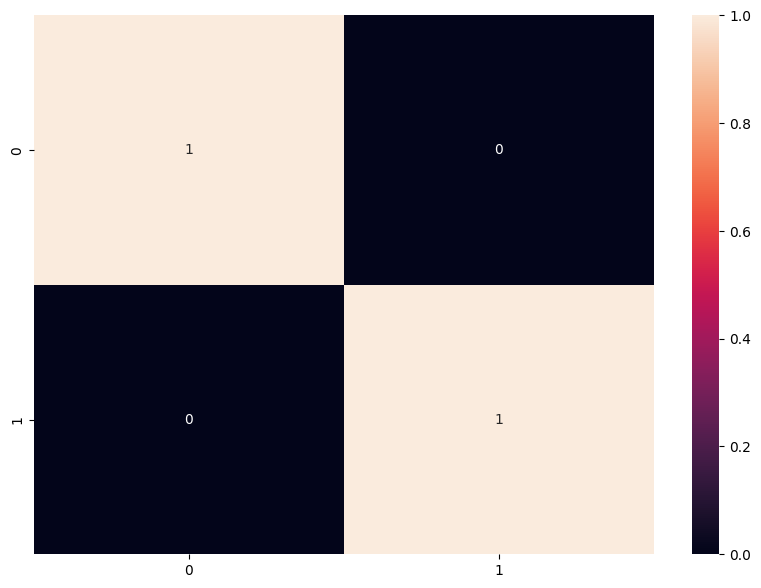

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


y_pred = model.predict(x_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("P,R,F1:",precision_recall_fscore_support(y_test, y_pred, average='macro'))
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred,normalize = 'true'), index = [i for i in "01"],
              columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
from google.colab import files
f = files.upload()

Saving sig4.jpg to sig4.jpg


In [ ]:
import numpy as np

img = Image.open("/content/sig4.jpg")
img_tensor = transform(img)
batch = img_tensor.unsqueeze(0).to("cuda")
features = extract_features(batch).cpu().numpy()

torch.Size([69, 322, 3])


In [ ]:
pred = model.predict(features)

In [ ]:
pred

array([0])

In [ ]:
import joblib

joblib.dump(model, "/content/handwrittings_classification_model.joblib", compress=3)

['/content/handwrittings_classification_model.joblib']